## Predicting the load

import libs

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib as plot
import  matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

### Read the data

In [2]:
data = sio.loadmat('data/PowerValuesOctMay.mat')

In [3]:
data

{'MeasurementsTotal': array([[129.33672838, 134.72952621, 130.95473543, ..., 133.16816453,
         144.20171743, 131.13069585]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Mar 22 19:13:26 2019',
 '__version__': '1.0'}

In [17]:
df = pd.DataFrame({'measurements':data['MeasurementsTotal'][0]})
time_index = pd.date_range('10/5/2014', periods=len(df), freq='H')
df['time'] = time_index
df.set_index('time',inplace=True)
df.head()

,measurements
time,
2014-10-05 00:00:00,129.336728
2014-10-05 01:00:00,134.729526
2014-10-05 02:00:00,130.954735
2014-10-05 03:00:00,128.923580
2014-10-05 04:00:00,127.021535


#### Get the basic stats of the data

In [18]:
df.describe().round(2)

,measurements
count,5736.00
mean,174.44
std,56.33
min,27.50
25%,135.91
50%,149.98
75%,218.41
max,323.78


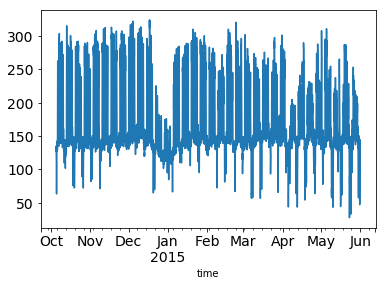

In [19]:
df['measurements'].plot(fontsize = 14)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a8fe320>]],
      dtype=object)

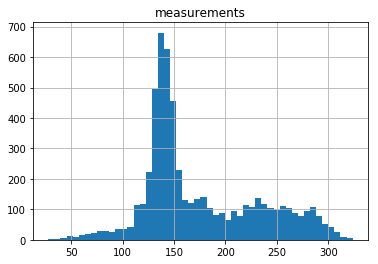

In [20]:
df.hist(bins=50)

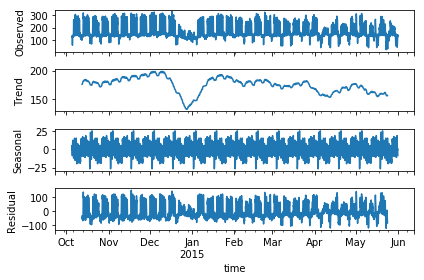

In [21]:
fig = seasonal_decompose(df['measurements'], model='additive', freq=365).plot()

## Start the RIMA model

In [22]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import datetime

In [23]:
p_train = 0.8 # split the data where 80% is in the train
df_train, df_test = df[:int(p_train*len(df))], df[int(p_train*len(df)):]

In [26]:
df_train.head()

,measurements
time,
2014-10-05 00:00:00,129.336728
2014-10-05 01:00:00,134.729526
2014-10-05 02:00:00,130.954735
2014-10-05 03:00:00,128.923580
2014-10-05 04:00:00,127.021535


In [27]:
df_test.head()

,measurements
time,
2015-04-14 04:00:00,135.847584
2015-04-14 05:00:00,142.397796
2015-04-14 06:00:00,153.046457
2015-04-14 07:00:00,177.299466
2015-04-14 08:00:00,208.784570


### Remove trend

In [13]:
dftest = adfuller(df_train['measurements'], autolag='AIC')

In [14]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -7.828261e+00
p-value                        6.394692e-12
#Lags Used                     2.800000e+01
Number of Observations Used    4.559000e+03
Critical Value (1%)           -3.431785e+00
Critical Value (10%)          -2.567108e+00
Critical Value (5%)           -2.862174e+00
dtype: float64

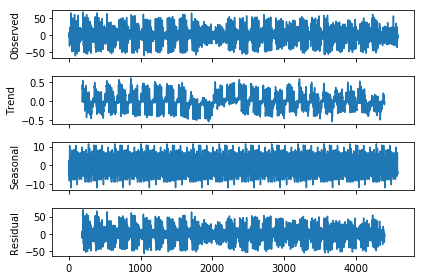

In [15]:
diff_1 = df_train['measurements'].diff(1)
diff_1.dropna(inplace=True)
fig = seasonal_decompose(diff_1, model='additive', freq=365).plot()

In [16]:
dftest = adfuller(diff_1, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.649997e+01
p-value                        2.153150e-29
#Lags Used                     2.800000e+01
Number of Observations Used    4.558000e+03
Critical Value (1%)           -3.431785e+00
Critical Value (10%)          -2.567108e+00
Critical Value (5%)           -2.862174e+00
dtype: float64

#### ACF

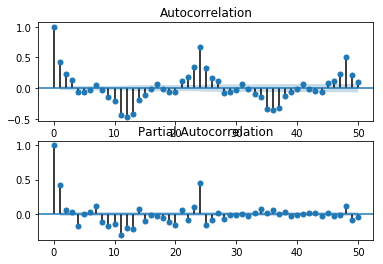

In [17]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(diff_1, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(diff_1, lags=50, ax=ax[1])

### Do grid search to fit ARIMA model

In [18]:
from itertools import product

ps = range(10, 24) # Up to 7 AR terms
d = 1            # Differencing is 1
qs = range(10, 20) # Up to 7 MA terms

params = product(ps, qs)
params_list = list(params)
print("Number of parameter combinations in grid search: {}".format(len(params_list)))

Number of parameter combinations in grid search: 441


In [ ]:
results = []
best_aic = np.inf

for param in params_list:
    print('\n##########################')
    print('p = {}, q = {}'.format(param[0], param[1]))
    try:
        arima = sm.tsa.ARIMA(df_train['measurements'].astype(float),
                             order=(param[0], d, param[1])).fit()
    except:
        continue
    aic = arima.aic
    print('AIC = {}'.format(aic))
    if aic < best_aic:
        best_model = arima
        best_aic = aic
        best_param = param

    results.append([param, arima.aic])

df_results = pd.DataFrame(results)
print(results)
df_results.columns = ['parameters', 'aic']
df_results = df_results.sort_values(by='aic', ascending=True).reset_index(drop=True)
    


##########################
p = 4, q = 4
AIC = 38207.924520502944

##########################
p = 4, q = 5
AIC = 38111.381040829896

##########################
p = 4, q = 6
AIC = 38116.337312579206

##########################
p = 4, q = 7


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37878.121729497405

##########################
p = 4, q = 8


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37325.139002710726

##########################
p = 4, q = 9


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37241.78703853926

##########################
p = 4, q = 10


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37240.742455772765

##########################
p = 4, q = 11
AIC = 37328.000483767646

##########################
p = 4, q = 12
AIC = 37691.70472252823

##########################
p = 4, q = 13


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37179.89418991677

##########################
p = 4, q = 14


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37113.58068742968

##########################
p = 4, q = 15


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36939.40226748738

##########################
p = 4, q = 16


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36997.509311667025

##########################
p = 4, q = 17


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37172.25795182631

##########################
p = 4, q = 18


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37149.83174540614

##########################
p = 4, q = 19


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36989.55157557141

##########################
p = 4, q = 20


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36983.43653643574

##########################
p = 4, q = 21
AIC = 37145.379163758

##########################
p = 4, q = 22
AIC = 37078.85344452927

##########################
p = 4, q = 23
AIC = 36870.3671968785

##########################
p = 4, q = 24

##########################
p = 5, q = 4


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37957.282519535845

##########################
p = 5, q = 5


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC = 37852.13345982319

##########################
p = 5, q = 6


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37714.3237009478

##########################
p = 5, q = 7


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC = 37788.88543686211

##########################
p = 5, q = 8


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37717.095123126695

##########################
p = 5, q = 9
AIC = 37559.30197843096

##########################
p = 5, q = 10
AIC = 37644.542353199926

##########################
p = 5, q = 11
AIC = 37322.084633049046

##########################
p = 5, q = 12


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37191.604923075814

##########################
p = 5, q = 13


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37066.59907996014

##########################
p = 5, q = 14


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37001.23061514115

##########################
p = 5, q = 15


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36981.61561206507

##########################
p = 5, q = 16


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36975.53128819631

##########################
p = 5, q = 17


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37157.93946940152

##########################
p = 5, q = 18


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37017.95661989891

##########################
p = 5, q = 19
AIC = 36953.10640513675

##########################
p = 5, q = 20
AIC = 36957.12376530164

##########################
p = 5, q = 21


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC = 36958.398244790355

##########################
p = 5, q = 22
AIC = 36896.105310688115

##########################
p = 5, q = 23
AIC = 36741.76176958476

##########################
p = 5, q = 24

##########################
p = 6, q = 4


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:632: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()



##########################
p = 6, q = 5
AIC = 37799.35229568955

##########################
p = 6, q = 6


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36940.373913258474

##########################
p = 6, q = 7


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC = 37446.68577715695

##########################
p = 6, q = 8


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37891.50420202187

##########################
p = 6, q = 9


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC = 37670.894396303906

##########################
p = 6, q = 10
AIC = 37601.72406668127

##########################
p = 6, q = 11
AIC = 37312.900005192714

##########################
p = 6, q = 12


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37257.52490214017

##########################
p = 6, q = 13


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37071.08734046364

##########################
p = 6, q = 14


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36952.16639841588

##########################
p = 6, q = 15


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()



##########################
p = 6, q = 16


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36953.20742740006

##########################
p = 6, q = 17


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37135.87691559539

##########################
p = 6, q = 18


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36940.10509602507

##########################
p = 6, q = 19


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC = 36897.2334630134

##########################
p = 6, q = 20
AIC = 36957.939269806026

##########################
p = 6, q = 21


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36562.923202350954

##########################
p = 6, q = 22
AIC = 36875.441900775215

##########################
p = 6, q = 23
AIC = 36722.75848753862

##########################
p = 6, q = 24

##########################
p = 7, q = 4


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC = nan

##########################
p = 7, q = 5


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC = nan

##########################
p = 7, q = 6


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC = 36860.281774068724

##########################
p = 7, q = 7


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36992.701505246776

##########################
p = 7, q = 8


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37622.78576667118

##########################
p = 7, q = 9


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36933.23943171615

##########################
p = 7, q = 10


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37179.11458915037

##########################
p = 7, q = 11


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36566.41656317236

##########################
p = 7, q = 12

##########################
p = 7, q = 13

##########################
p = 7, q = 14

##########################
p = 7, q = 15

##########################
p = 7, q = 16

##########################
p = 7, q = 17

##########################
p = 7, q = 18

##########################
p = 7, q = 19

##########################
p = 7, q = 20

##########################
p = 7, q = 21


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36568.937062397075

##########################
p = 7, q = 22


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36574.32196756313

##########################
p = 7, q = 23
AIC = 36726.46313436019

##########################
p = 7, q = 24

##########################
p = 8, q = 4
AIC = 37575.43803952834

##########################
p = 8, q = 5
AIC = 37420.002770251675

##########################
p = 8, q = 6


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 37005.15488013247

##########################
p = 8, q = 7
AIC = 37119.44230595022

##########################
p = 8, q = 8


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36392.09899141995

##########################
p = 8, q = 9


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36343.87687364071

##########################
p = 8, q = 10


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36339.67863070409

##########################
p = 8, q = 11


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36336.43844542003

##########################
p = 8, q = 12


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36275.70606667716

##########################
p = 8, q = 13


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36299.93271067779

##########################
p = 8, q = 14


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36234.25086284675

##########################
p = 8, q = 15


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36169.38141728417

##########################
p = 8, q = 16


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36162.36297429287

##########################
p = 8, q = 17


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36159.78385898794

##########################
p = 8, q = 18


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36160.7639915535

##########################
p = 8, q = 19


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36165.964356066805

##########################
p = 8, q = 20


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36140.40644164318

##########################
p = 8, q = 21


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36145.23374617546

##########################
p = 8, q = 22


/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 36162.0053152718

##########################
p = 8, q = 23

##########################
p = 8, q = 24

##########################
p = 9, q = 4


In [21]:
df_results.head()

,parameters,aic
0,"(7, 6)",36860.281774
1,"(6, 6)",36940.373913
2,"(7, 7)",36992.701505
3,"(6, 7)",37446.685777
4,"(5, 6)",37714.323701


### Fit the best model

In [75]:
arima2 = sm.tsa.ARIMA(df['measurements'].astype(float),order=(24, 1, 20),freq='H').fit()
print(arima.summary())
arima2.aic

/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/salehi/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


44036.072773668944

### make Predictions

In [87]:
df.tail()

,measurements
time,
2015-05-31 19:00:00,124.016933
2015-05-31 20:00:00,129.802988
2015-05-31 21:00:00,133.168165
2015-05-31 22:00:00,144.201717
2015-05-31 23:00:00,131.130696


In [99]:
time_index_predic = pd.date_range('6/1/2015', periods=24*6, freq='H')

In [98]:
forecast, stderr, conf = arima2.forecast(6*24)

In [117]:
df_predict = pd.DataFrame({
        'forcast': forecast,
        'stderr': stderr,
        'conf_interval_below': conf[:,0],
        'conf_interval_up': conf[:,1],
    }, index = time_index_predic)
df_predict.index.name = 'time'

In [132]:
df_predict.loc[pd.datetime(2015,6,5,11)].round(2)

conf_interval_below   -107.51
conf_interval_up       296.86
forcast                 94.68
stderr                 103.16
Name: 2015-06-05 11:00:00, dtype: float64

In [133]:
df_predict.loc[pd.datetime(2015,6,5,21)].round(2)

conf_interval_below   -117.34
conf_interval_up       301.40
forcast                 92.03
stderr                 106.83
Name: 2015-06-05 21:00:00, dtype: float64

In [134]:
df_predict.loc[pd.datetime(2015,6,6,15)].round(2)

conf_interval_below   -127.82
conf_interval_up       317.75
forcast                 94.97
stderr                 113.67
Name: 2015-06-06 15:00:00, dtype: float64